In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
import vaemof
from vaemof import experiments
from vaemof import utils
from vaemof.vocabs import SELFIESVocab, MOFVocab, PropVocab
from vaemof import modules
from vaemof import training
from vaemof.model import VAEMOF
from vaemof import configs
from vaemof.utils import header_str
vaemof.experiments.plot_settings()

In [14]:
import os
import random
from tqdm.auto import tqdm
import numpy as np
import torch
import rdkit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from itertools import product
from more_itertools import chunked
from collections import OrderedDict

print(f'rdkit : {rdkit.__version__}')
print(f'torch : {torch.__version__}')
print(f'cuda? {torch.cuda.is_available()}')
tqdm.pandas()
utils.disable_rdkit_log()

rdkit : 2019.09.3
torch : 1.4.0
cuda? True


/home/beangoben/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Hparams

In [15]:
preset = 'full'
WORK_DIR = 'results/test/'
hparams = configs.get_model_config(WORK_DIR, preset, rand=False)
print(utils.header_str(preset))
hparams['train_device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

testing = configs.testing_config(hparams)
configs.print_config(hparams)
utils.set_seed(hparams['train_seed'])
device = torch.device(hparams['train_device'])

===================================== full =====================================
==================================== config ====================================
== train == :
        train_device:                cuda
          train_seed:                  42
    train_batch_size:                1536
        train_epochs:                 120
            train_lr:        0.0005705023
     train_clip_grad:                  20
== vae == :
      vae_latent_dim:                 288
           vae_y_dec:                True
     vae_selfies_dec:                True
         vae_mof_enc:                True
         vae_mof_dec:                True
vae_duplicate_smiles:                True
== mof == :
        mof_encoding:                cats
   mof_weighted_loss:                True
         mof_w_start:                 0.0
           mof_w_end:                 0.1
           mof_start:                   0
    mof_const_length:                  10
== y == :
            y_labels:['lcd', 'pld'

## Load MOF data

Assemble smiles formula: [organic core][metal_node][topology][branch_smiles]

In [16]:
smiles_column = 'branch_smiles'
testtrain_column = 'train/best'
df = experiments.get_generator_df(csv_file=hparams['files_data'],
                                  smiles_column=smiles_column,
                                  use_duplicates=hparams['vae_duplicate_smiles'],
                                  testing=testing)
ids2mofs, mof2ids, mof_columns = experiments.get_mofdict(
    df, hparams['mof_encoding'])
df.head()

=================================== Real run ===================================
df shape: (2049964, 8)
df columns: ['branch_smiles', 'id2mof', 'metal_node', 'mof_index', 'organic_core', 'randomized', 'topology', 'train/test']
Found 713 unique mofs


,branch_smiles,id2mof,metal_node,mof_index,organic_core,randomized,topology,train/test
0,CC(c1cc(O)cc(O)c1)(C(Sc1cc(O)cc(O)c1)c1cc(O)cc...,0,sym_7_mc_4,4.0,None,False,acs,1
1,Oc1ccc(-c2cc(/C=C/c3c(-c4ccc(O)cc4)cc([Lr])c(-...,0,sym_7_mc_4,10.0,None,False,acs,1
2,O=S(=O)(O)Cc1nn([Lr])c(CS(=O)(=O)O)c1-c1c(CS(=...,0,sym_7_mc_4,18.0,None,False,acs,1
3,[Lr]c1ccc(-c2c(-c3ccccc3)cc([Lr])c(-c3ccccc3)c...,0,sym_7_mc_4,23.0,None,False,acs,1
4,[Lr]c1ccc(N2C=C(c3ccncc3)N(c3c(-c4ccncc4)cc([L...,0,sym_7_mc_4,29.0,None,False,acs,1


## Load property data

In [17]:
prop_df = experiments.get_prop_df(csv_file=hparams['files_prop'],
                                  targets=hparams['y_labels'],
                                  mof2ids=mof2ids,
                                  testing=testing,
                                  smiles_column=smiles_column,
                                  compute_scscore=True)
prop_df.head()

=================================== Real run ===================================
Restored variables from data/scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz



Removed 2923 datapoints due to mask.
Removed 1819 datapoints due non-valid mof (mof2ids).
Removed 245 datapoints due to high selectivity.


,organic_core,metal_node,topology,branch_smiles,lcd,pld,density,avf,avsa,agsa,...,co2ch4_selectivity,co2ch4_heat_avg,co2ch4_heat_co2,co2ch4_heat_ch4,co2ch4_heat_molfrac,selfies_safe,mask,train/test,scscore,id2mof
0,None,sym_7_mc_4,acs,COc1c(/C=C/c2ccc([Lr])cc2)cc(OC)c(/C=C/c3ccc([...,24.87798,19.29733,0.164554,0.75459,1159.130,7044.060,...,1.786937,-8.58733,-12.08169,-7.92879,-8.61737,True,True,1,3.384814,0
1,None,sym_7_mc_4,acs,CSC1=C2CCC(=C(C(=C2SC)[Lr])SC)C(=C1[Lr])SC,7.78281,5.18969,1.119280,0.07631,978.891,874.575,...,3.197185,-20.54264,-24.18495,-18.74239,-20.17205,True,True,0,3.176298,0
2,None,sym_7_mc_4,acs,O=C(c1cc(O)c(cc1O)[Lr])OOC(=O)c1cc(O)c(cc1O)[Lr],17.01677,15.91720,0.320703,0.61736,1628.620,5078.290,...,3.004385,-11.22187,-16.39748,-9.43473,-11.17660,True,True,1,2.668208,0
3,None,sym_7_mc_4,acs,Oc1c(cc(c(c1O)[Lr])O)c1nnc(nn1)c1ccc(c(c1)O)[Lr],19.50569,17.17410,0.291374,0.66206,1401.740,4810.800,...,2.250807,-9.49245,-13.39225,-8.37161,-9.37550,True,True,1,3.688210,0
4,None,sym_7_mc_4,acs,[Lr]C12C=CC(C=C1)(C=C2)[Lr],9.58653,8.21739,0.799733,0.24196,2020.860,2526.910,...,2.167731,-15.36924,-18.34929,-14.67475,-15.38911,True,True,1,1.831772,0


## Train/test splits and hparams

In [18]:
train_index = np.array(df[df[testtrain_column] == 1].index.tolist())
test_index = np.array(df[df[testtrain_column] == 0].index.tolist())
prop_train_index = np.array(
    prop_df[prop_df[testtrain_column] == 1].index.tolist())
prop_test_index = np.array(
    prop_df[prop_df[testtrain_column] == 0].index.tolist())
print(f'Train sizes: {len(train_index):7d} and {len(prop_train_index):7d}')
print(f'Test  sizes: {len(test_index):7d} and {len(prop_test_index):7d}')

Train sizes: 1894967 and   36795
Test  sizes:  154997 and    4107


# Vocabulary and preprocessors

In [19]:
smiles_list = df[smiles_column].tolist()+prop_df[smiles_column].tolist()
vocab = SELFIESVocab.from_data(smiles_list)
vocab_mof = MOFVocab.from_data(df.append(
    prop_df, sort=False), mof_columns, weighting=hparams['mof_weighted_loss'])
vocab_y = PropVocab.from_data(
    prop_df, hparams['y_labels'], hparams['y_weights'], hparams['scaler_type'])
vocab, vocab_mof, vocab_y


Alphabet size is 73
Max seq length is 109 with 5 extra padding
Used columns =['metal_node', 'organic_core', 'topology'] with frequency weighting=True
metal_node   has 15 classes
organic_core has 52 classes
topology     has 41 classes


(<vaemof.vocabs.SELFIESVocab at 0x7f9d06e34f10>,
 <vaemof.vocabs.PropVocab at 0x7f9f6c0cd0d0>)

# Instanciate Model

## Careful! (it saves and will overwrite any model previously saved)

In [20]:
try:
    utils.clear_torch(model)
except:
    utils.clear_torch(model=None)

model = VAEMOF(hparams, vocab, vocab_mof, vocab_y).to(device)
model.save()
modules.model_summary(model, include_children=False)

,Name,Module,Extra,submodule,trainable,n_params,trainable_params
0,z_mu,Linear,"in_features=576, out_features=288, bias=True",False,True,166176,166176
1,z_logvar,Linear,"in_features=576, out_features=288, bias=True",False,True,166176,166176
2,enc_x,CharEncoder,,False,True,2388096,2388096
3,dec_x,CharDecoder,,False,True,2510792,2510792
4,enc_mof,MOFEncoder,,False,True,280800,280800
5,dec_mof,MOFDecoder,,False,True,114552,114444
6,dec_y,PropDecoder,,False,True,6090,6069


Trainable params: 5627369 out of 5627498 total (100.00%)


## Prepare train/test 

In [21]:
train_mof = model.df_to_tuples(df.loc[train_index], smiles_column)
test_mof = model.df_to_tuples(df.loc[test_index], smiles_column)
prop_train = model.df_to_tuples(prop_df.loc[prop_train_index], smiles_column)
prop_test = model.df_to_tuples(prop_df.loc[prop_test_index], smiles_column)
train_data = train_mof + prop_train
test_data = test_mof + prop_test

## Train

In [22]:
trainer = training.Trainer(hparams)
trainer.train(model, train_data, test_data)

In [23]:
hparams_file = os.path.join(WORK_DIR,'config.json')
hparams = configs.AttributeDict.from_jsonfile(hparams_file)
configs.print_config(hparams)
model = VAEMOF.load(hparams)
test_mof = model.df_to_tuples(df.loc[test_index], smiles_column)
prop_test = model.df_to_tuples(prop_df.loc[prop_test_index], smiles_column)
len(test_mof), len(prop_test)

Restored variables from data/scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz
==================================== config ====================================
== train == :
        train_device:                cuda
          train_seed:                  42
    train_batch_size:                1536
        train_epochs:                 120
            train_lr:0.0005705023000000001
     train_clip_grad:                  20
== vae == :
      vae_latent_dim:                 288
           vae_y_dec:                True
     vae_selfies_dec:                True
         vae_mof_enc:                True
         vae_mof_dec:                True
vae_duplicate_smiles:                True
== mof == :
        mof_encoding:                cats
   mof_weighted_loss:                True
         mof_w_start:                 0.0
           mof_w_end:                 0.1
           mof_start:                   0
    mof_const_length:                  10
== y == :
            y_labels:['lcd', 'pld

/home/beangoben/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


(154997, 4107)

## Training stats

In [24]:
log_df = pd.read_csv(configs.at_results_dir(hparams,'files_log'))
print(log_df.shape)
print(log_df.columns)
log_df.head()

(120, 69)
Index(['epoch', 'test_kl', 'test_x', 'test_mof', 'test_y', 'test_loss',
       'lcd-r2', 'lcd-MAE', 'pld-r2', 'pld-MAE', 'density-r2', 'density-MAE',
       'avf-r2', 'avf-MAE', 'avsa-r2', 'avsa-MAE', 'agsa-r2', 'agsa-MAE',
       'co2n2_co2_mol_kg-r2', 'co2n2_co2_mol_kg-MAE', 'co2n2_n2_mol_kg-r2',
       'co2n2_n2_mol_kg-MAE', 'co2n2_selectivity-r2', 'co2n2_selectivity-MAE',
       'co2n2_heat_avg-r2', 'co2n2_heat_avg-MAE', 'co2n2_heat_co2-r2',
       'co2n2_heat_co2-MAE', 'co2n2_heat_n2-r2', 'co2n2_heat_n2-MAE',
       'co2n2_heat_molfrac-r2', 'co2n2_heat_molfrac-MAE',
       'co2ch4_co2_mol_kg-r2', 'co2ch4_co2_mol_kg-MAE', 'co2ch4_ch4_mol_kg-r2',
       'co2ch4_ch4_mol_kg-MAE', 'co2ch4_selectivity-r2',
       'co2ch4_selectivity-MAE', 'co2ch4_heat_avg-r2', 'co2ch4_heat_avg-MAE',
       'co2ch4_heat_co2-r2', 'co2ch4_heat_co2-MAE', 'co2ch4_heat_ch4-r2',
       'co2ch4_heat_ch4-MAE', 'co2ch4_heat_molfrac-r2',
       'co2ch4_heat_molfrac-MAE', 'scscore-r2', 'scscore-MAE', 'lr'

,epoch,test_kl,test_x,test_mof,test_y,test_loss,lcd-r2,lcd-MAE,pld-r2,pld-MAE,...,mof_acc,mean_r2,train_kl_ratio,train_x_ratio,train_mof_ratio,train_y_ratio,test_kl_ratio,test_x_ratio,test_mof_ratio,test_y_ratio
0,0,873.977101,0.466041,10.514139,5.303599,0.474781,0.995236,22.813490,0.916463,88.403290,...,3.126886,0.297536,0.008498,0.991502,0.000000,0.000000,0.018408,0.981592,0.000000,0.000000
1,1,280.034385,0.225776,2.489756,1.451842,0.284138,0.959198,78.868088,0.968705,39.932430,...,68.231052,0.748792,0.145076,0.757506,0.009108,0.088310,0.192789,0.794600,0.007966,0.004645
2,2,165.107939,0.126225,0.873333,1.437440,0.193371,0.985914,47.980183,0.994816,18.382374,...,87.739047,0.791241,0.218490,0.555679,0.008481,0.217350,0.325509,0.652764,0.008212,0.013516
3,3,124.098473,0.080610,0.452309,1.473415,0.156206,0.973999,64.426041,0.997137,13.412242,...,93.681491,0.758810,0.260468,0.370003,0.006243,0.363286,0.450330,0.516048,0.007897,0.025725
4,4,104.245488,0.058839,0.437604,1.407115,0.143987,0.986872,46.423584,0.916262,65.299828,...,93.682120,0.836263,0.277316,0.244584,0.005818,0.472283,0.544773,0.408639,0.011052,0.035536


,epoch,test_kl,test_x,test_mof,test_y,test_loss,lcd-r2,lcd-MAE,pld-r2,pld-MAE,...,mof_acc,mean_r2,train_kl_ratio,train_x_ratio,train_mof_ratio,train_y_ratio,test_kl_ratio,test_x_ratio,test_mof_ratio,test_y_ratio
0,0,873.977101,0.466041,10.514139,5.303599,0.474781,0.995236,22.813490,0.916463,88.40329,...,3.126886,0.297536,0.008498,0.991502,0.000000,0.00000,0.018408,0.981592,0.000000,0.000000
1,1,280.034385,0.225776,2.489756,1.451842,0.284138,0.959198,78.868088,0.968705,39.93243,...,68.231052,0.748792,0.145076,0.757506,0.009108,0.08831,0.192789,0.794600,0.007966,0.004645


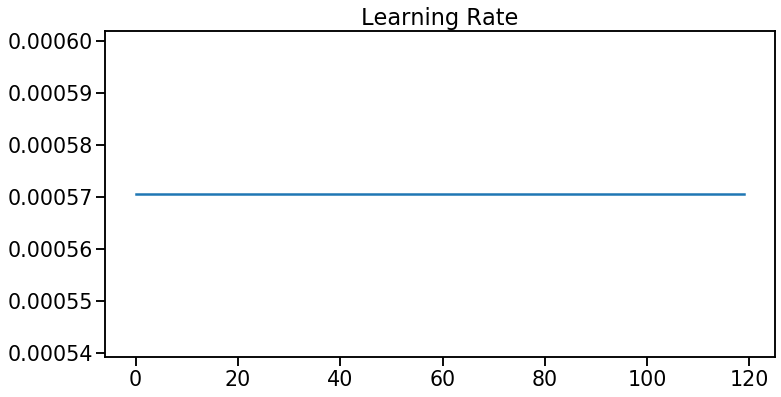

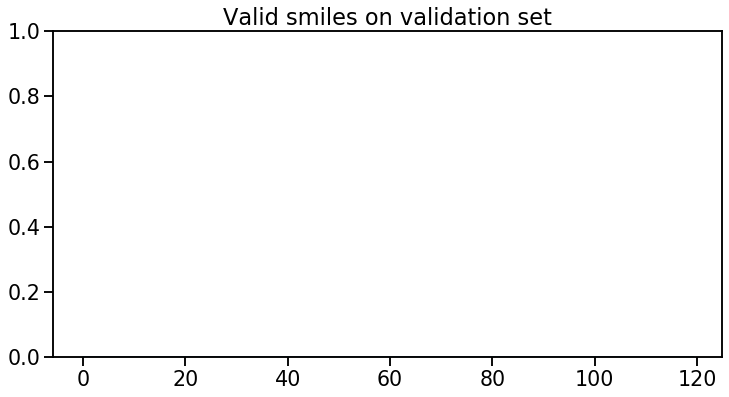

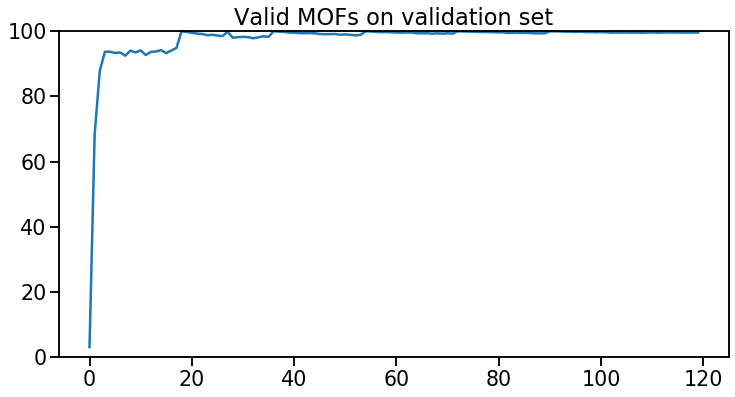

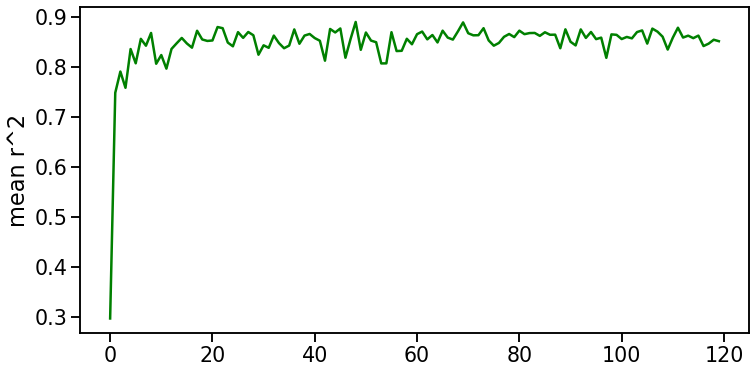

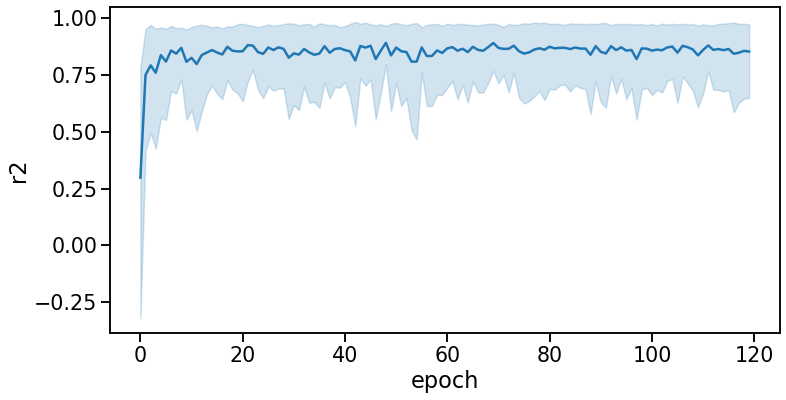

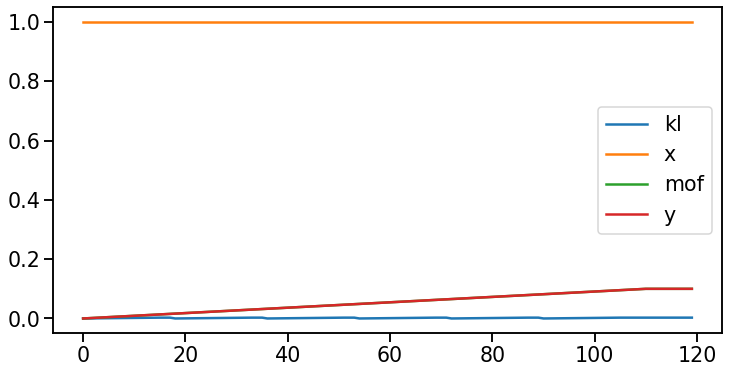

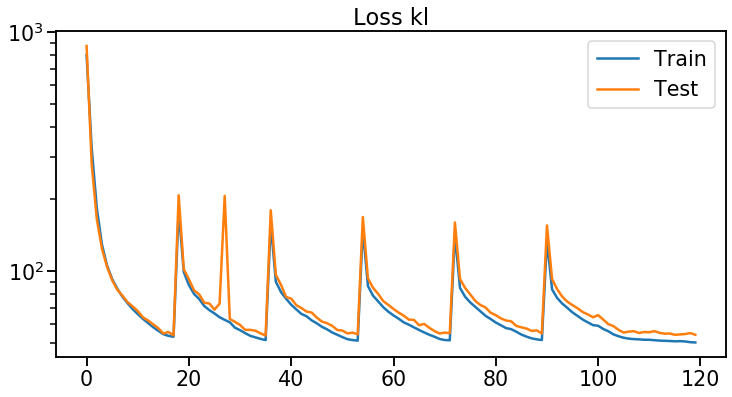

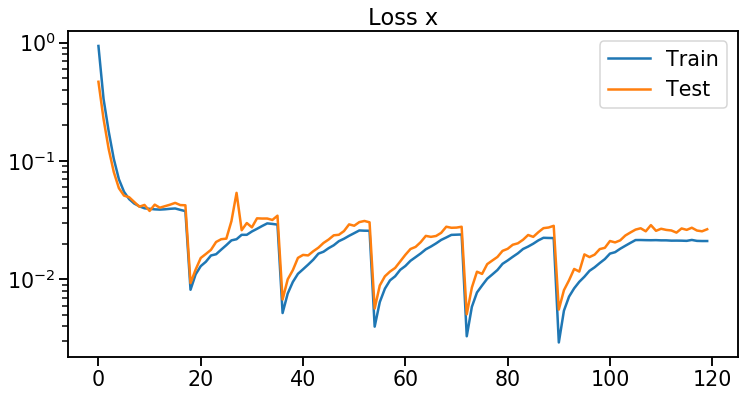

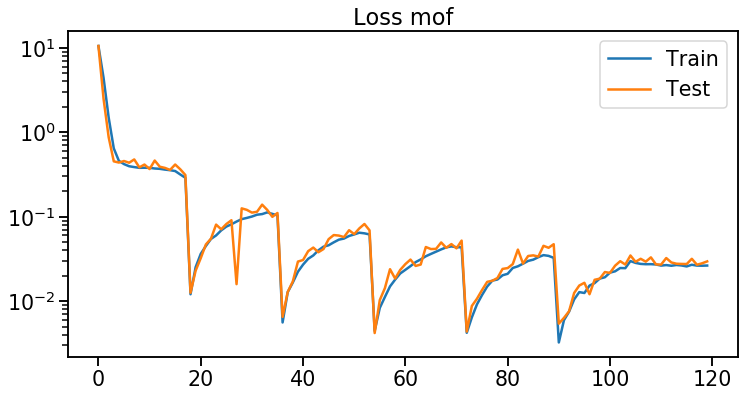

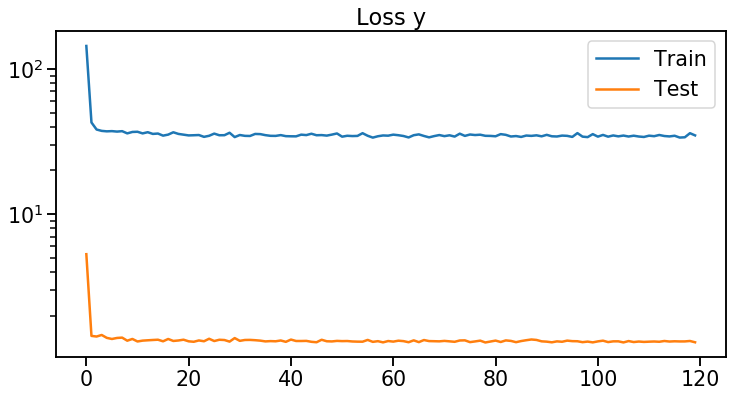

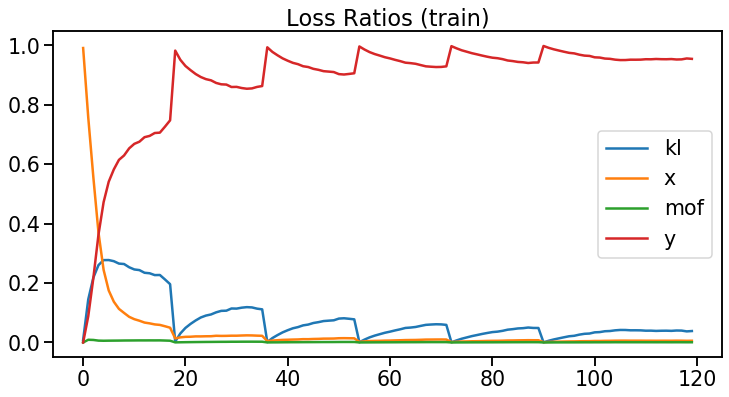

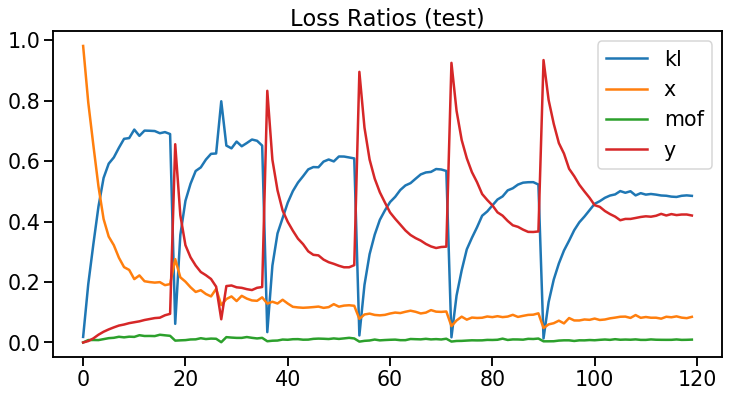

In [25]:
COMPONENTS = training.COMPONENTS
epochs = log_df['epoch'].values

display(log_df.head(2))
plt.plot(epochs, log_df['lr'])
plt.title('Learning Rate')
plt.show()

plt.plot(epochs, log_df['valid_smiles'])
plt.title('Valid smiles on validation set')
plt.ylim([0,1])
plt.show()

plt.plot(epochs, log_df['mof_acc'])
plt.title('Valid MOFs on validation set')
plt.ylim([0,100])
plt.show()

plt.plot(epochs, log_df['mean_r2'],c='g',label='valid')
plt.ylabel('mean r^2')
plt.show()

results=[]
for label in hparams['y_labels']:
    metric = f'{label}-r2'
    results.extend([{'epoch':epoch,'r2':value,"prop":label} for epoch, value in log_df[['epoch',metric]].values ]  )
prop_df = pd.DataFrame(results)
sns.lineplot(x='epoch',y='r2', data=prop_df)
plt.show()

for label in COMPONENTS:
    plt.plot(epochs, log_df[f'λ_{label}'], label =label)
plt.legend()
plt.show()

for label in COMPONENTS:
    plt.plot(epochs, log_df[f'train_{label}'], label='Train')
    plt.plot(epochs, log_df[f'test_{label}'], label='Test')
    plt.title(f'Loss {label}')
    plt.yscale("log")
    plt.legend()
    plt.show()

for prefix in ['train','test']:
    for label in COMPONENTS:
        plt.plot(epochs, log_df[f'{prefix}_{label}_ratio'], label=label) 
    plt.title(f'Loss Ratios ({prefix})')
    plt.legend()
    plt.show()